Hi!

This notebooks presents a guide for segmenting the autosimilarity of a song using the Convolutive Block-Matching (CBM) algorithm.

It presents a simple example (Come Together, from The Beatles), and present results on different spectrograms (Chromagram, Log Mel spectrogram and MFCC).

Feel free to play with this code! (like changing the song, the parameters, digging into the code, etc)

# Imports

In [1]:
# External imports
# Module for manipulating arrays
import numpy as np

# Module for reading signals
import soundfile as sf

# Module to handle annotations for MIR files
import mirdata

Now, let's import the code we need. It's organized in modules, which should group "coherent" codes in themselves.

In [2]:
# Module encapsulating the computation of features from the signal
import as_seg.model.features as features

# General module for manipulating data: conversion between time, bars, frame indexes, loading of data, ...
import as_seg.data_manipulation as dm

# Module to process the input in barwise features
import as_seg.barwise_input as bi

# Module to process the compute the autosimilarity
import as_seg.autosimilarity_computation as as_computation

# Module containing the CBM algorithm
import as_seg.CBM_algorithm as cbm

# Plotting module
from as_seg.model.current_plot import *

# Loading the song, its annotations, and preparing it

Now, let's load the song (as a wav).

If you want to test in our example (Come Together, from the Beatles), you'll need to load the wav from your PC, but the rest of the data (like the annotations) will be downloaded automatically thanks to the package `mirdata`!

In that case, you need to modify the variable `path_to_beatles_dataset`, specifying where you want Betales annotation to be downloaded, and place the wav "01_-\_Come_Together.wav" in the folder "audio/11_-\_Abbey_Road/".

If you want to test on your own example, you'll need to change the variable `song_path`, and load manually your annotations (or no annotation at all if you don't need to test on the segmentation task and just visualize results).

In [3]:
path_to_beatles_dataset = 'C:/Users/amarmore/this_folder/Beatles dataset/'
beatles = mirdata.initialize('beatles', path_to_beatles_dataset)
beatles.download()

# NB: you have to place the file "01_-_Come_Together.wav" manually in the folder "audio/11_-_Abbey_Road/"
come_together = beatles.track('1101')

references_segments = beatles.load_sections(come_together.sections_path).intervals

song_path = come_together.audio_path

INFO: Downloading ['annotations'] to C:/Users/amarmore/this_folder/Beatles dataset/
INFO: [annotations] downloading The Beatles Annotations.tar.gz
INFO: C:/Users/amarmore/this_folder/Beatles dataset/annotations\The Beatles Annotations.tar.gz already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: 
    Unfortunately the audio files of the Beatles dataset are not available
    for download. If you have the Beatles dataset, place the contents into
    a folder called Beatles with the following structure:
        > Beatles/
            > annotations/
            > audio/
    and copy the Beatles folder to C:/Users/amarmore/this_folder/Beatles dataset/



Loading the song as signal, and estimating bars of this song (using the `madmom` external library).

In [4]:
the_signal, sampling_rate = sf.read(song_path)
bars = dm.get_bars_from_audio(song_path)

C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\neural_net\lib\site-packages\madmom\io\audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


# Load feature
## Overall parameters

In [5]:
hop_length = 32 # Oversampling the spectrogram, to select frames which will be equally-spaced barwise.
hop_length_seconds = hop_length/sampling_rate # As bars are in seconds, we convert this hop length in seconds.
subdivision_bars = 96 # The number of time samples to consider in each bar.

## Chromagram

In [6]:
chromas = features.get_spectrogram(the_signal, sampling_rate, "pcp", hop_length = hop_length)
freq_len = chromas.shape[0]

### Cosine autosimilarity

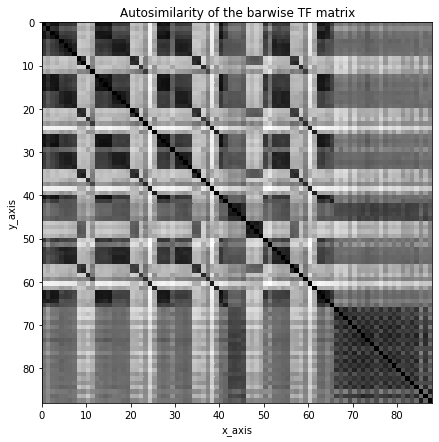

In [7]:
barwise_TF_chromas = bi.barwise_TF_matrix(chromas, bars, hop_length_seconds, subdivision_bars)
barwise_TF_chromas_autosimilarity = as_computation.get_cosine_autosimilarity(barwise_TF_chromas)
plot_me_this_spectrogram(barwise_TF_chromas_autosimilarity, title = "Autosimilarity of the barwise TF matrix")

### CBM algorithm on this autosimilarity

In [8]:
segments_cbm_chromas = cbm.compute_cbm(barwise_TF_chromas_autosimilarity, penalty_weight = 1, penalty_func = "modulo8", convolution_type = "mixed")[0]
segments_cbm_chromas_in_time = dm.segments_from_bar_to_time(segments_cbm_chromas, bars)

score_cbm_chromas_zero_five = dm.compute_score_of_segmentation(references_segments, segments_cbm_chromas_in_time, window_length = 0.5)
print(f"Score with 0.5 second tolerance: Precision {score_cbm_chromas_zero_five[0]}, Recall {score_cbm_chromas_zero_five[1]}, F measure {score_cbm_chromas_zero_five[2]}")
score_cbm_chromas_three = dm.compute_score_of_segmentation(references_segments, segments_cbm_chromas_in_time, window_length = 3)
print(f"Score with 3 seconds tolerance: Precision {score_cbm_chromas_three[0]}, Recall {score_cbm_chromas_three[1]}, F measure {score_cbm_chromas_three[2]}")

Score with 0.5 second tolerance: Precision 0.47058823529411764, Recall 0.6666666666666666, F measure 0.5517241379310345
Score with 3 seconds tolerance: Precision 0.47058823529411764, Recall 0.6666666666666666, F measure 0.5517241379310345


## Log Mel Spectrogram

In [9]:
log_mel = features.get_spectrogram(the_signal, sampling_rate, "log_mel_grill", hop_length = hop_length)
freq_len = log_mel.shape[0]

### Cosine autosimilarity

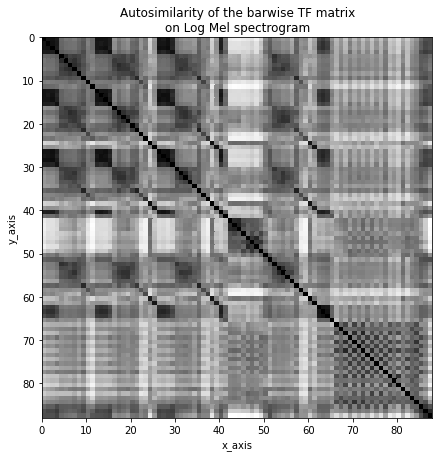

In [10]:
barwise_TF_log_mel = bi.barwise_TF_matrix(log_mel, bars, hop_length_seconds, subdivision_bars)
barwise_TF_log_mel_autosimilarity = as_computation.get_cosine_autosimilarity(barwise_TF_log_mel)
plot_me_this_spectrogram(barwise_TF_log_mel_autosimilarity, title = "Autosimilarity of the barwise TF matrix\non Log Mel spectrogram")

### CBM algorithm on this autosimilarity

In [11]:
segments_cbm_log_mel = cbm.compute_cbm(barwise_TF_log_mel_autosimilarity, penalty_weight = 1, penalty_func = "modulo8", convolution_type = "mixed")[0]
segments_cbm_log_mel_in_time = dm.segments_from_bar_to_time(segments_cbm_log_mel, bars)

score_cbm_log_mel_zero_five = dm.compute_score_of_segmentation(references_segments, segments_cbm_log_mel_in_time, window_length = 0.5)
print(f"Score with 0.5 second tolerance: Precision {score_cbm_log_mel_zero_five[0]}, Recall {score_cbm_log_mel_zero_five[1]}, F measure {score_cbm_log_mel_zero_five[2]}")
score_cbm_log_mel_three = dm.compute_score_of_segmentation(references_segments, segments_cbm_log_mel_in_time, window_length = 3)
print(f"Score with 3 seconds tolerance: Precision {score_cbm_log_mel_three[0]}, Recall {score_cbm_log_mel_three[1]}, F measure {score_cbm_log_mel_three[2]}")

Score with 0.5 second tolerance: Precision 0.4, Recall 0.5, F measure 0.4444444444444445
Score with 3 seconds tolerance: Precision 0.4, Recall 0.5, F measure 0.4444444444444445


## MFCC

In [12]:
mfcc = features.get_spectrogram(the_signal, sampling_rate, "mfcc", n_mfcc = 32, hop_length = hop_length)

### Cosine autosimilarity

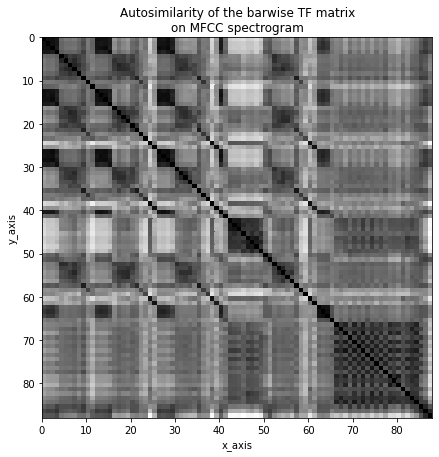

In [13]:
barwise_TF_mfcc = bi.barwise_TF_matrix(mfcc, bars, hop_length_seconds, subdivision_bars)
barwise_TF_mfcc_autosimilarity = as_computation.get_cosine_autosimilarity(barwise_TF_mfcc)
plot_me_this_spectrogram(barwise_TF_mfcc_autosimilarity, title = "Autosimilarity of the barwise TF matrix\non MFCC spectrogram")

### CBM algorithm on this autosimilarity

In [14]:
segments_cbm_mfcc = cbm.compute_cbm(barwise_TF_mfcc_autosimilarity, penalty_weight = 1, penalty_func = "modulo8", convolution_type = "mixed")[0]
segments_cbm_mfcc_in_time = dm.segments_from_bar_to_time(segments_cbm_mfcc, bars)

score_cbm_mfcc_zero_five = dm.compute_score_of_segmentation(references_segments, segments_cbm_mfcc_in_time, window_length = 0.5)
print(f"Score with 0.5 second tolerance: Precision {score_cbm_mfcc_zero_five[0]}, Recall {score_cbm_mfcc_zero_five[1]}, F measure {score_cbm_mfcc_zero_five[2]}")
score_cbm_mfcc_three = dm.compute_score_of_segmentation(references_segments, segments_cbm_mfcc_in_time, window_length = 3)
print(f"Score with 3 seconds tolerance: Precision {score_cbm_mfcc_three[0]}, Recall {score_cbm_mfcc_three[1]}, F measure {score_cbm_mfcc_three[2]}")

Score with 0.5 second tolerance: Precision 0.42857142857142855, Recall 0.5, F measure 0.4615384615384615
Score with 3 seconds tolerance: Precision 0.42857142857142855, Recall 0.5, F measure 0.4615384615384615


# Conclusion
We've presented a tutorial for autoencoding songs, and evaluates the resulting latent projection in the structural segmentation task.

This code could, theoretically, be used for any song and any feature, modulo some adjustements in the code.

Finally, as a test conclusion, let's compare the results on the above features:

In [15]:
import pandas as pd
columns = np.array(["Precision 0.5", "Recall 0.5", "F measure 0.5","Precision 3", "Recall 3", "F measure 3"])  
tab = []
tab.append([round(score_cbm_chromas_zero_five[0],5), round(score_cbm_chromas_zero_five[1],5),round(score_cbm_chromas_zero_five[2],5),round(score_cbm_chromas_three[0],5),round(score_cbm_chromas_three[1],5),round(score_cbm_chromas_three[2],5)])
tab.append([round(score_cbm_log_mel_zero_five[0],5), round(score_cbm_log_mel_zero_five[1],5),round(score_cbm_log_mel_zero_five[2],5),round(score_cbm_log_mel_three[0],5),round(score_cbm_log_mel_three[1],5),round(score_cbm_log_mel_three[2],5)])
tab.append([round(score_cbm_mfcc_zero_five[0],5), round(score_cbm_mfcc_zero_five[1],5),round(score_cbm_mfcc_zero_five[2],5),round(score_cbm_mfcc_three[0],5),round(score_cbm_mfcc_three[1],5),round(score_cbm_mfcc_three[2],5)])

display(pd.DataFrame(tab, index=["Chromas", "Log Mel", "MFCC"], columns=columns))

,Precision 0.5,Recall 0.5,F measure 0.5,Precision 3,Recall 3,F measure 3
Chromas,0.47059,0.66667,0.55172,0.47059,0.66667,0.55172
Log Mel,0.40000,0.50000,0.44444,0.40000,0.50000,0.44444
MFCC,0.42857,0.50000,0.46154,0.42857,0.50000,0.46154
